In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score



from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from livelossplot import PlotLossesKerasTF
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

os.environ['CUDA_VISIBLE_DEVICES'] =  ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] =  ''

os.environ['XLA_FLAGS'] = ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices



2022-02-24 18:24:57.059906: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import numpy as np
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree as ctree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['b', 'r'][int(rect[4])]
        print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        plt.gca().add_artist(rp)

In [3]:
D = 2
N = 5000
seed = 5

depth = 3

In [4]:
#class0_data = np.random.normal(0,1, (N, D))
#class1_data = np.random.normal(1,1, (N, D)) 

min_param_1 = 0
max_param_1 = 2

min_param_2 = 0
max_param_2 = 2

distribution_name = 'normal'

distrib_param_list = []

if True:
    data_list = []

    for i in range(D):
        np.random.seed(seed+i)
        
        flip = np.random.randint(0,2)
        print(flip)
        if flip == 0:
            param_0_d1 = np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
        else:
            param_0_d1 = np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)            
        
        if distribution_name == 'normal':
            class0_data_feature = np.random.normal(loc=param_0_d1, scale=param_1_d1, size=N)
            class1_data_feature = np.random.normal(loc=param_0_d2, scale=param_1_d2, size=N)
        elif distribution_name == 'uniform':
            class0_data_feature = np.random.uniform(low=min(param_0_d1, param_1_d1), high=max(param_0_d1, param_1_d1), size=N)
            class1_data_feature = np.random.uniform(low=min(param_0_d2, param_1_d2), high=max(param_0_d2, param_1_d2), size=N)                    
        elif distribution_name == 'gamma':  
            class0_data_feature = np.random.gamma(shape=param_0_d1, scale=param_1_d1, size=N) #shape: The shape of the gamma distribution. Must be non-negative. 
            class1_data_feature = np.random.gamma(shape=param_0_d2, scale=param_1_d2, size=N) #scale: The scale of the gamma distribution. Must be non-negative. Default is equal to 1.
        elif distribution_name == 'exponential':    
            class0_data_feature = np.random.exponential(scale=param_0_d1, size=N) #The scale parameter. Must be non-negative.
            class1_data_feature = np.random.exponential(scale=param_0_d2, size=N)              
        elif distribution_name == 'beta':
            class0_data_feature = np.random.beta(a=param_0_d1, b=param_1_d1, size=N)
            class1_data_feature = np.random.beta(a=param_0_d2, b=param_1_d2, size=N)                
        elif distribution_name == 'binomial':   
            class0_data_feature = np.random.binomial(n=100, p=param_1_d1, size=N)
            class1_data_feature = np.random.binomial(n=100, p=param_1_d2, size=N)               
        elif distribution_name == 'poisson':
            class0_data_feature = np.random.poisson(lam=param_0_d1, size=N)
        
        
        data_feature = np.hstack([class0_data_feature, class1_data_feature])

        data_list.append(data_feature)
        distrib_param_list.append([param_0_d1, param_1_d1, param_0_d2, param_1_d2])
        
    X_data = np.hstack([data_list]).T  
    y_data = np.hstack([[0]*N, [1]*N]).reshape(-1,1).astype(np.int64)

else:
    data_list = []
    data_weight_list = []

    for i in range(D):
        np.random.seed(seed+i)
        #loc_0 = np.random.uniform(-1,1)
        #loc_1 = np.random.uniform(-1,1)

        #scale_0 = np.random.uniform(0,2)
        #scale_1 = np.random.uniform(0,2)
        
        if distribution_name == 'normal':
            class0_data_feature = np.random.normal(loc=param_0_d1, scale=param_1_d1, size=N)
            class1_data_feature = np.random.normal(loc=param_0_d2, scale=param_1_d2, size=N)
        elif distribution_name == 'uniform':
            class0_data_feature = np.random.uniform(low=param_0_d1, high=param_1_d1, size=N)
            class1_data_feature = np.random.uniform(low=param_0_d2, high=param_1_d2, size=N)                    
        elif distribution_name == 'gamma':  
            class0_data_feature = np.random.gamma(shape=param_0_d1, scale=param_1_d1, size=N) #shape: The shape of the gamma distribution. Must be non-negative. 
            class1_data_feature = np.random.gamma(shape=param_0_d2, scale=param_1_d2, size=N) #scale: The scale of the gamma distribution. Must be non-negative. Default is equal to 1.
        elif distribution_name == 'exponential':    
            class0_data_feature = np.random.exponential(scale=param_0_d1, size=N) #The scale parameter. Must be non-negative.
            class1_data_feature = np.random.exponential(scale=param_0_d2, size=N)              
        elif distribution_name == 'beta':
            class0_data_feature = np.random.beta(a=param_0_d1, b=param_1_d1, size=N)
            class1_data_feature = np.random.beta(a=param_0_d2, b=param_1_d2, size=N)                
        elif distribution_name == 'binomial':   
            class0_data_feature = np.random.binomial(n=100, p=param_1_d1, size=N)
            class1_data_feature = np.random.binomial(n=100, p=param_1_d2, size=N)               
        elif distribution_name == 'poisson':
            class0_data_feature = np.random.poisson(lam=param_0_d1, size=N)
                
        data_feature = np.hstack([class0_data_feature, class1_data_feature])
        data_weight_feature = np.hstack([[0]*N, [1]*N])#.reshape(-1,1)

        np.random.seed(seed+i)
        np.random.shuffle(data_feature)
        np.random.seed(seed+i)
        np.random.shuffle(data_weight_feature)    
        data_list.append(data_feature)
        data_weight_list.append(data_weight_feature)

    X_data = np.hstack([data_list]).T
    X_data_weights = np.vstack([data_weight_list]).T

    y_data_list = []
    for X_data_weights_row in X_data_weights:
        label_sum = np.sum(X_data_weights_row)
        if label_sum < D/2:
            y_data_list.append(0)
        elif label_sum > D/2:
            y_data_list.append(1)
        else:
            y_data_list.append(np.random.randint(0, 2))

    y_data = np.array(y_data_list).reshape(-1,1).astype(np.int64)    
    
for i, column in enumerate(X_data.T):
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    X_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()

data = np.hstack([X_data, y_data])

columns = ['feature_' + str(i) for i in range(D)]
columns.append('class')

print('Feature 1:')
print('Distribution 1:', distrib_param_list[0][0], distrib_param_list[0][1])
print('Distribution 2:', distrib_param_list[0][2], distrib_param_list[0][3])
print('Feature 2:')
print('Distribution 1:', distrib_param_list[1][0], distrib_param_list[1][1])
print('Distribution 2:', distrib_param_list[1][2], distrib_param_list[1][3])

df = pd.DataFrame(data=data, columns=columns)
df.head()

1
0
Feature 1:
Distribution 1: 1.5275900619876843 1.6818684485502948
Distribution 2: 0.41566391738772074 0.489722499580723
Feature 2:
Distribution 1: 0.47373803828649147 0.03212730229532951
Distribution 2: 1.604703183551241 1.6850547012226904


,feature_0,feature_1,class
0,0.420217,0.385049,0.0
1,0.338130,0.389337,0.0
2,0.419877,0.386693,0.0
3,0.142636,0.383204,0.0
4,0.595835,0.381839,0.0


In [5]:
#sns.scatterplot(data=df, x="feature_0", y="feature_1", hue='class')

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=seed)

In [7]:
if False:
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(X_train[:,:2], y_train)

    y_valid_pred = tree.predict(X_valid[:,:2])
    print('Accuracy 2 Features', accuracy_score(y_valid, y_valid_pred))

    try:
        plt.figure(figsize=(15, 15))
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

        rectangles = decision_areas(tree, [0, 1, 0, 1])
        plot_areas(rectangles)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    except:
        pass

In [8]:
if False:
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(X_train, y_train)

    feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))

    y_valid_pred = tree.predict(X_valid)
    print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))

    try:
        plt.figure(figsize=(15, 15))
        plt.scatter(X_train[:, feature_index[0]], X_train[:, feature_index[1]], c=y_train)

        rectangles = decision_areas(tree, [0, 1, 0, 1])
        plot_areas(rectangles)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    except:
        pass

In [9]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=D, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), bias_initializer='zeros'))

model.add(Dense(1, 
                activation='sigmoid', 
                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), 
                bias_initializer='zeros'))


optimizer = tf.keras.optimizers.get('adam')
optimizer.learning_rate = 0.001

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',#tf.keras.losses.get(config['lambda_net']['loss_lambda']),
              metrics=[tf.keras.metrics.get("binary_accuracy")]
             )

model.fit(X_train, 
          y_train,
          batch_size=64,
          epochs=50,
          #callbacks=[PlotLossesKerasTF()]
         )

y_valid_pred = np.round(model.predict(X_valid)).astype(np.int64)
print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))


2022-02-24 18:24:59.338061: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-24 18:24:59.380709: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-24 18:24:59.380737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dws-15
2022-02-24 18:24:59.380743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dws-15
2022-02-24 18:24:59.380885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-02-24 18:24:59.380907: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-02-24 18:24:59.380912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-02-24 18:24:59.381237: I tensorflow/core/platform/cpu_feature_gua

Epoch 1/50
125/125 [==============================] - 0s 557us/step - loss: 0.7027 - binary_accuracy: 0.5111
Epoch 2/50
125/125 [==============================] - 0s 617us/step - loss: 0.6716 - binary_accuracy: 0.6275
Epoch 3/50
125/125 [==============================] - 0s 617us/step - loss: 0.6194 - binary_accuracy: 0.7937
Epoch 4/50
125/125 [==============================] - 0s 629us/step - loss: 0.5527 - binary_accuracy: 0.7750
Epoch 5/50
125/125 [==============================] - 0s 630us/step - loss: 0.4979 - binary_accuracy: 0.7768
Epoch 6/50
125/125 [==============================] - 0s 647us/step - loss: 0.4586 - binary_accuracy: 0.7922
Epoch 7/50
125/125 [==============================] - 0s 684us/step - loss: 0.4269 - binary_accuracy: 0.8164
Epoch 8/50
125/125 [==============================] - 0s 690us/step - loss: 0.3989 - binary_accuracy: 0.8419
Epoch 9/50
125/125 [==============================] - 0s 661us/step - loss: 0.3732 - binary_accuracy: 0.8536
Epoch 10/50
125/125

Accuracy All Features 0.9605
0.0 1.0 0.0 -0.6424702554941177
0.0 1.0 0.35752974450588226 -0.63814577460289
0.0 1.0 0.36185422539711 -0.6309998035430908
0.0 1.0 0.3690001964569092 -0.6050267070531845
0.0 0.39188116788864136 0.3949732929468155 0.012137055397033691
0.39188116788864136 1.0 0.0030921250581741333 -0.595981776714325
0.0 0.2517794072628021 0.40401822328567505 0.7482205927371979
0.2517794072628021 1.0 0.15223881602287292 0.0


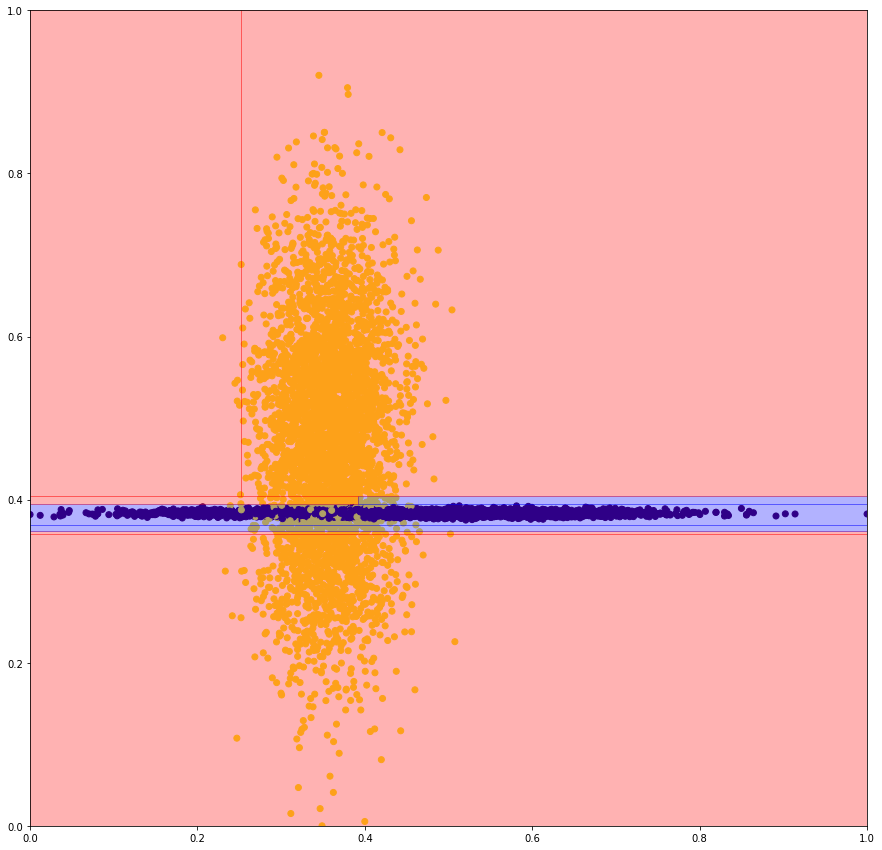

In [10]:
tree = DecisionTreeClassifier(max_depth=depth)

y_train_network = np.round(model.predict(X_train)).astype(np.int64)

tree.fit(X_train, y_train_network)

feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))

y_valid_pred = tree.predict(X_valid)
print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))

try:
    plt.figure(figsize=(15, 15))
    plt.scatter(X_train[:, feature_index[0]], X_train[:, feature_index[1]], c=y_train)

    rectangles = decision_areas(tree, [0, 1, 0, 1])
    plot_areas(rectangles)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
except:
    pass

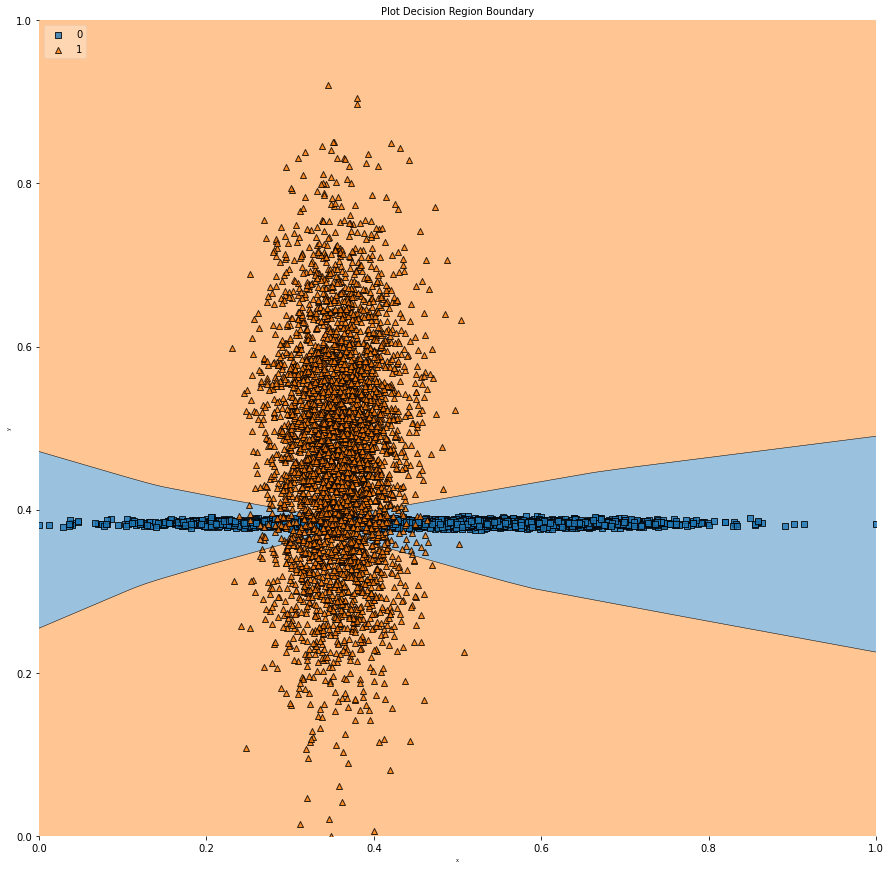

In [11]:
from mlxtend.plotting import plot_decision_regions

feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))
filler_features = list(np.sort(np.argsort(tree.feature_importances_)[::-1][2:]))

#plot_decision_regions(X=X_train, y=y_train.ravel(), clf=model, legend=2)

value=0.5
width=0.5

filler_feature_values = {}
filler_feature_ranges = {}
for feature in filler_features:
    filler_feature_values[feature] = value
    filler_feature_ranges[feature] = width

plt.figure(figsize=(15, 15))
plot_decision_regions(X=X_train,
                      y=y_train.ravel(), 
                      clf=model,
                      feature_index=feature_index,#[0,1],                        #these one will be plotted  
                      filler_feature_values=filler_feature_values,#{2: value, 3:value},  #these will be ignored
                      filler_feature_ranges=filler_feature_ranges,#{2: width, 3: width}, 
                      legend=2)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('Plot Decision Region Boundary', size=10)
plt.show()

Accuracy All Features 0.5415
0.0 1.0 0.0 -0.739020586013794
0.0 1.0 0.26097941398620605 -0.7163166552782059
0.0 0.6352288126945496 0.28368334472179413 -0.16133427619934082
0.6352288126945496 1.0 -0.35154546797275543 -0.5261054635047913
0.0 0.8977048099040985 0.47389453649520874 -0.41610510647296906
0.8977048099040985 1.0 -0.42381027340888977 -0.5184002965688705
0.0 1.0 0.48159970343112946 0.0


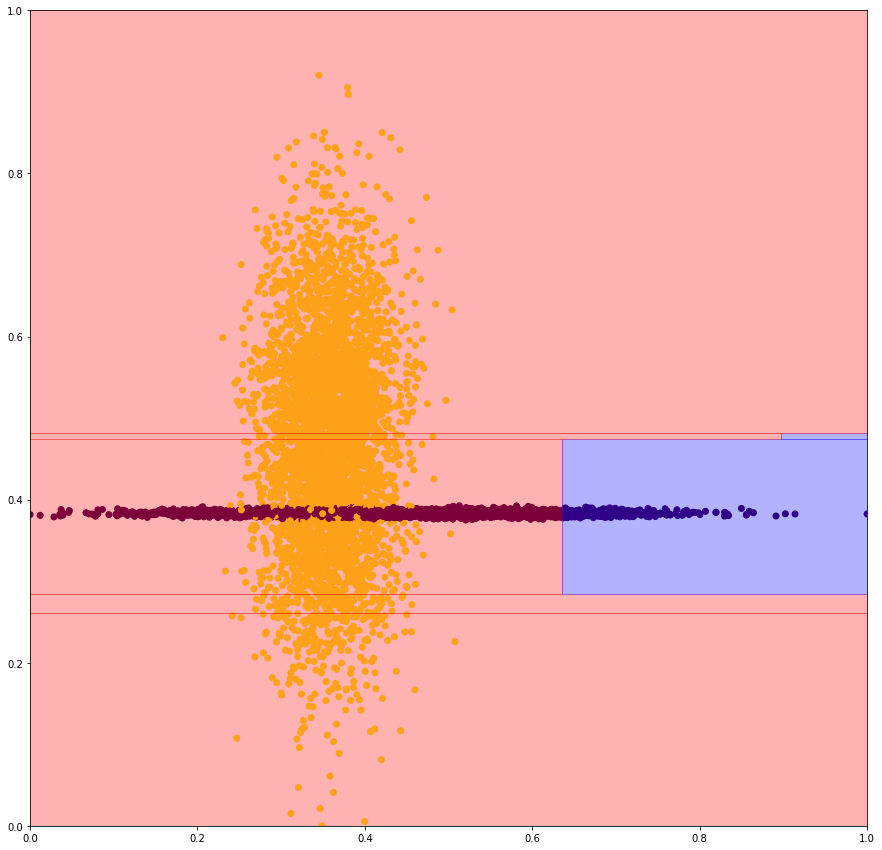

In [12]:
tree = DecisionTreeClassifier(max_depth=depth)

random_data = np.random.uniform(0,1, (y_train.shape[0],D))
random_data_labels = np.round(model.predict(random_data)).astype(np.int64)

tree.fit(random_data, random_data_labels)

feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))

y_valid_pred = tree.predict(X_valid)
print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))

try:
    plt.figure(figsize=(15, 15))
    plt.scatter(X_train[:, feature_index[0]], X_train[:, feature_index[1]], c=y_train)

    rectangles = decision_areas(tree, [0, 1, 0, 1])
    plot_areas(rectangles)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
except:
    pass